# Think Bayes

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

### The height problem

For adult male residents of the US, the mean and standard deviation of height are 178 cm and 7.7 cm.  For adult female residents the corresponding stats are 163 cm and 7.3 cm.  Suppose you learn that someone is 170 cm tall.  What is the probability that they are male? 

Run this analysis again for a range of observed heights from 150 cm to 200 cm, and plot a curve that shows P(male) versus height.  What is the mathematical form of this function?

To represent the likelihood functions, I'll use `norm` from `scipy.stats`, which returns a "frozen" random variable (RV) that represents a normal distribution with given parameters.


In [2]:
from scipy.stats import norm

dist_height = dict(male=norm(178, 7.7),
                   female=norm(163, 7.3))

{'male': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f2dd4254be0>,
 'female': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f2dd4254da0>}

Write a class that implements `Likelihood` using the frozen distributions.  Here's starter code:

In [3]:
class Height(Suite):
    
    def Likelihood(self, data, hypo):
        """
        data: height in cm
        hypo: 'male' or 'female'
        """
        return 1

In [4]:
# Solution

class Height(Suite):
    
    def Likelihood(self, data, hypo):
        """
        data: height in cm
        hypo: 'male' or 'female'
        """
        height = data
        return dist_height[hypo].pdf(height)

Here's the prior.

In [5]:
suite = Height(['male', 'female'])
for hypo, prob in suite.Items():
    print(hypo, prob)

male 0.5
female 0.5


And the update:

In [6]:
suite.Update(170)
for hypo, prob in suite.Items():
    print(hypo, prob)

male 0.4667199136812651
female 0.5332800863187349


Compute the probability of being male as a function of height, for a range of values between 150 and 200.

In [7]:
# Solution

heights = np.linspace(150, 200)
prob_male = pd.Series(index=heights)

for height in heights:
    suite = Height(['male', 'female'])
    suite.Update(height)
    prob_male[height] = suite['male']

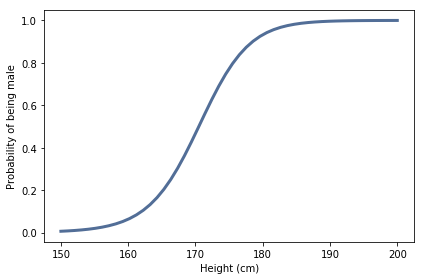

In [8]:
# Solution

thinkplot.plot(prob_male)
thinkplot.decorate(xlabel='Height (cm)',
                   ylabel='Probability of being male')

If you are curious, you can derive the mathematical form of this curve from the PDF of the normal distribution.

### How tall is A?

Suppose I choose two residents of the U.S. at random.  A is taller than B.  How tall is A?

What if I tell you that A is taller than B by more than 5 cm.  How tall is A?

For adult male residents of the US, the mean and standard deviation of height are 178 cm and 7.7 cm.  For adult female residents the corresponding stats are 163 cm and 7.3 cm.

Here are distributions that represent the heights of men and women in the U.S.

In [9]:
dist_height = dict(male=norm(178, 7.7),
                   female=norm(163, 7.3))

{'male': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f2dd1090f60>,
 'female': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f2dd10903c8>}

In [10]:
hs = np.linspace(130, 210)
ps = dist_height['male'].pdf(hs)
male_height_pmf = Pmf(dict(zip(hs, ps)));

In [11]:
ps = dist_height['female'].pdf(hs)
female_height_pmf = Pmf(dict(zip(hs, ps)));

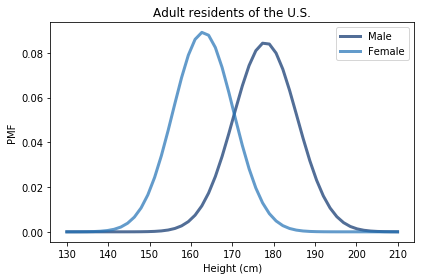

In [12]:
thinkplot.Pdf(male_height_pmf, label='Male')
thinkplot.Pdf(female_height_pmf, label='Female')

thinkplot.decorate(xlabel='Height (cm)',
                   ylabel='PMF',
                   title='Adult residents of the U.S.')

Use `thinkbayes2.MakeMixture` to make a `Pmf` that represents the height of all residents of the U.S.

In [13]:
# Solution

from thinkbayes2 import MakeMixture

metapmf = Pmf([male_height_pmf, female_height_pmf])
mix = MakeMixture(metapmf)
mix.Mean()

170.4998613968615

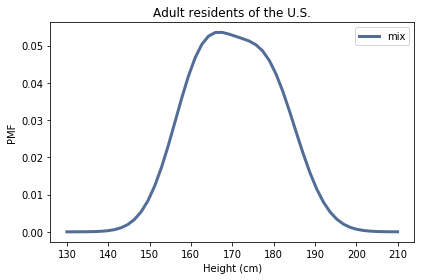

In [14]:
# Solution

thinkplot.Pdf(mix)

thinkplot.decorate(xlabel='Height (cm)',
                   ylabel='PMF',
                   title='Adult residents of the U.S.')

Write a class that inherits from Suite and Joint, and provides a Likelihood function that computes the probability of the data under a given hypothesis.

In [15]:
# Solution

class Heights(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: lower bound on the height difference
        hypo: h1, h2
        """
        h1, h2 = hypo 
        return 1 if h1 - h2 > data else 0

Write a function that initializes your `Suite` with an appropriate prior.

In [16]:
# Solution

def make_prior(mix):
    suite = Heights()

    for h1, p1 in mix.Items():
        for h2, p2 in mix.Items():
            suite[h1, h2] = p1 * p2
    return suite

In [17]:
suite = make_prior(mix)
suite.Total()

1.0000000000000024

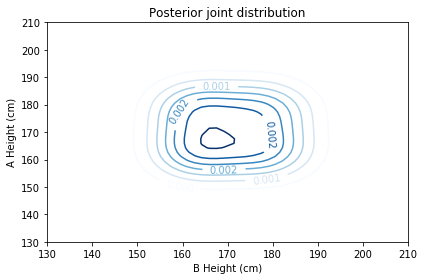

In [18]:
thinkplot.Contour(suite)
thinkplot.decorate(xlabel='B Height (cm)',
                   ylabel='A Height (cm)',
                   title='Posterior joint distribution')

Update your `Suite`, then plot the joint distribution and the marginal distribution, and compute the posterior means for `A` and `B`.

In [19]:
# Solution

suite.Update(0)

0.47898701183357106

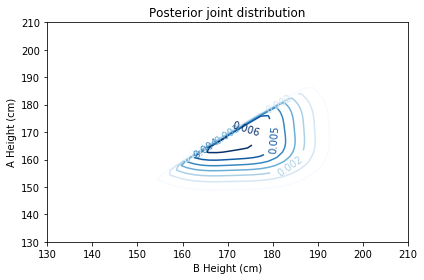

In [20]:
# Solution

thinkplot.Contour(suite)

thinkplot.decorate(xlabel='B Height (cm)',
                   ylabel='A Height (cm)',
                   title='Posterior joint distribution')

(176.8248792111856, 164.19708681755586)

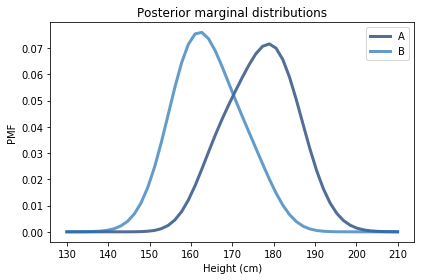

In [21]:
# Solution

posterior_a = suite.Marginal(0)
posterior_b = suite.Marginal(1)

thinkplot.Pdf(posterior_a, label='A')
thinkplot.Pdf(posterior_b, label='B')
thinkplot.decorate(xlabel='Height (cm)',
                   ylabel='PMF',
                   title='Posterior marginal distributions')

posterior_a.Mean(), posterior_b.Mean()

In [22]:
# Solution

suite = make_prior(mix)
suite.Update(5)
posterior_a = suite.Marginal(0)
posterior_b = suite.Marginal(1)
posterior_a.Mean(), posterior_b.Mean()

(178.52837301364738, 162.66048364246262)